In [415]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from pts.model.deepar import DeepAREstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts import time_feature
import json
from itertools import islice
from gluonts.dataset.field_names import FieldName
import numpy as np

In [2]:
model_input = pd.read_csv('xbr-xrlt.csv')
model_input['yyyymm'] = pd.to_datetime(model_input['yyyymm']) 
model_input.shape

(7708, 505)

In [3]:
features = [
            'yyyymm',
            'ccg_code',
            'sugg_accept_rate_1_to_7m',    #removed by me
            'nletter_open_rate_1_to_7m',   #removed by me
            'avg_nb_sugg_per_rep_1_to_7m',
            'com_nb_nletter_open_1_to_7m',
            'com_ratio_has_consent_in_wkp_1_to_7m',
            
            #'ttl_touch_1_to_7m',
            #'com_ratio_has_consent_in_wkp_1_to_7m',
            'xrlt_ms'
           ]

In [4]:
df = model_input[features]
df = df.set_index('yyyymm')
df = df.fillna(0)

In [994]:
df = df.sort_values(['ccg_code', 'yyyymm'])

In [1017]:
result_list = []

for col in input_cols:
    for item_id in df.ccg_code.unique():
        
        max_temp = max(df[(df.ccg_code==item_id)][col])
        min_temp = min(df[(df.ccg_code==item_id)][col])
        if max_temp > 0:
            result_list.append(df[(df.ccg_code==item_id)][col].apply(lambda x:(x-min_temp)/(max_temp)-min_temp))
        else:
            result_list.append(df[(df.ccg_code==item_id)][col].apply(lambda x: x))

In [1018]:
len(result_list)

752

In [1022]:
df['sugg_accept_rate_1_to_7m_new'] = result_list[0:188]

ValueError: Length of values (188) does not match length of index (7708)

In [1019]:
len(result_list)/4

188.0

In [1016]:
# Normalize input data:

input_cols = [ 'sugg_accept_rate_1_to_7m',    #removed by me
               'nletter_open_rate_1_to_7m',   #removed by me
               'avg_nb_sugg_per_rep_1_to_7m',
               'com_nb_nletter_open_1_to_7m']

for col in input_cols:
    max_temp = max(df[col])
    min_temp = min(df[col])
    df[col] = df[col].apply(lambda x: (x-min_temp)/(max_temp-min_temp))
    
df.describe()    

,sugg_accept_rate_1_to_7m,nletter_open_rate_1_to_7m,avg_nb_sugg_per_rep_1_to_7m,com_nb_nletter_open_1_to_7m,com_ratio_has_consent_in_wkp_1_to_7m,xrlt_ms
count,7708.000000,7708.000000,7708.000000,7708.000000,7708.000000,7708.000000
mean,0.009984,0.019388,0.016855,0.011141,0.040498,0.395160
std,0.067031,0.080215,0.067656,0.053111,0.083901,0.153318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.059217
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.286334
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.378080
75%,0.000000,0.000000,0.000000,0.000000,0.043478,0.488219
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.863636


### Train only with target series

In [503]:
table_target = pd.pivot_table(df, 
                           values='xrlt_ms', 
                           index=['ccg_code'],
                           columns=['yyyymm'],
                           aggfunc=np.sum)
table_target['target'] = table_target.apply(lambda x: np.array(x), axis=1)

target = np.array(table_target['target'].tolist())

In [504]:
freq='M'
start = df.index[0]
prediction_length=6

train_ds = ListDataset(
    [{'target': x, 'start': start} for x in target[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in target],
    freq=freq
)

In [505]:
# returns test and train dict

test_entry = next(iter(test_ds))
train_entry = next(iter(train_ds))

print(train_entry.keys(),
      test_entry.keys())

dict_keys(['target', 'start', 'source']) dict_keys(['target', 'start', 'source'])


In [506]:
# Inspect how train and test dict look:

print(train_entry)
print()
print(test_entry)

{'target': array([0.68740356, 0.70055735, 0.68368715, 0.67196983, 0.6667347 ,
       0.6554086 , 0.6652938 , 0.64573365, 0.6385187 , 0.64342844,
       0.64250916, 0.63350105, 0.6230409 , 0.61141443, 0.61665547,
       0.618621  , 0.6011318 , 0.6021195 , 0.59865296, 0.59208053,
       0.5941153 , 0.5808847 , 0.57631505, 0.5773291 , 0.600571  ,
       0.56164604, 0.5789036 , 0.5575289 , 0.5716073 , 0.56292105,
       0.5567726 , 0.5674944 , 0.5676967 , 0.5714186 , 0.5712432 ],
      dtype=float32), 'start': Timestamp('2017-08-31 00:00:00', freq='M'), 'source': SourceContext(source='list_data', row=0)}

{'target': array([0.68740356, 0.70055735, 0.68368715, 0.67196983, 0.6667347 ,
       0.6554086 , 0.6652938 , 0.64573365, 0.6385187 , 0.64342844,
       0.64250916, 0.63350105, 0.6230409 , 0.61141443, 0.61665547,
       0.618621  , 0.6011318 , 0.6021195 , 0.59865296, 0.59208053,
       0.5941153 , 0.5808847 , 0.57631505, 0.5773291 , 0.600571  ,
       0.56164604, 0.5789036 , 0.5575289 , 0.

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


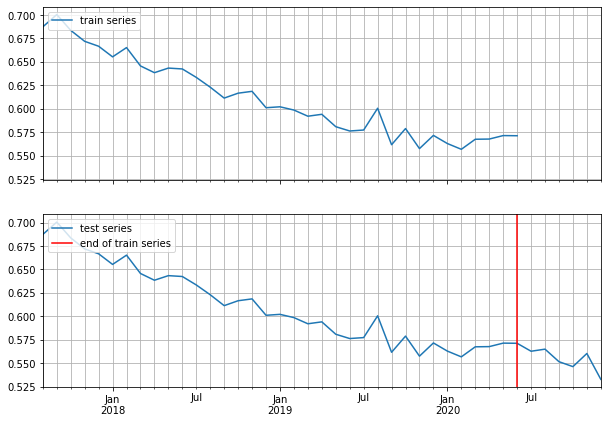

In [507]:
# plot train and testing data:

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [508]:
# Train DeepAR model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq='M',
                            prediction_length=prediction_length,
                            input_size=17,
                            context_length=4*prediction_length,
                            trainer=Trainer(epochs=5,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [509]:
# make forecast and compare to observed values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=50,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 188/188 [00:00<00:00, 1062.33it/s]/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = for

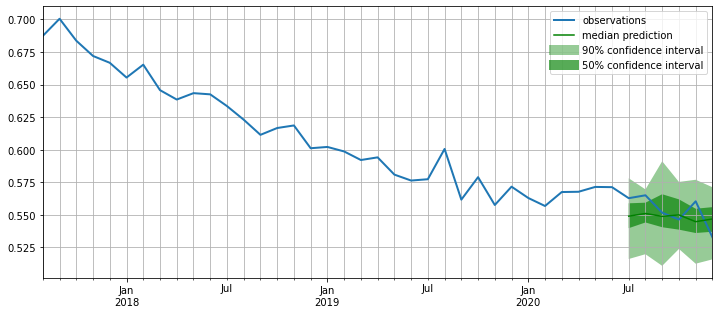

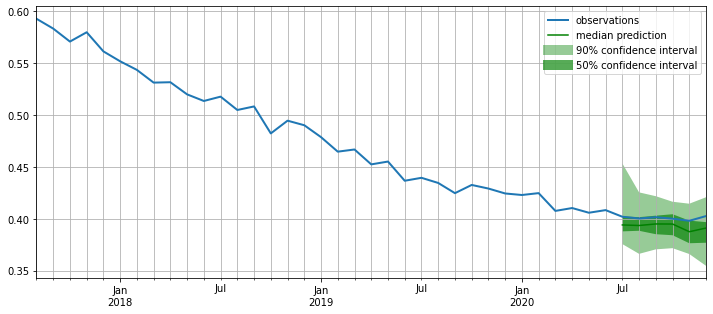

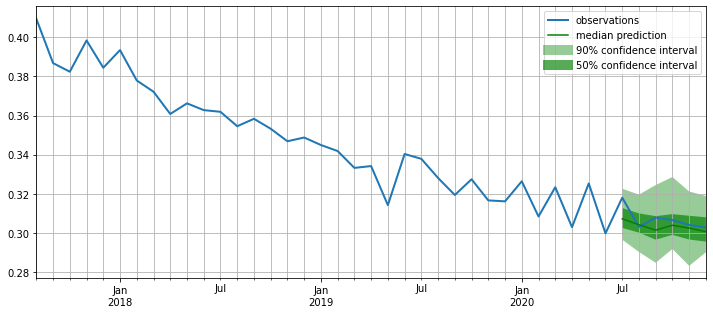

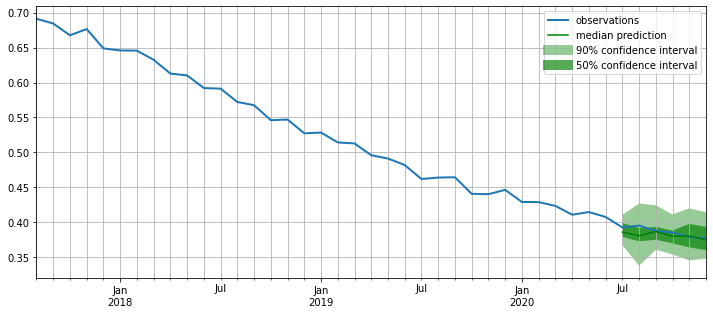

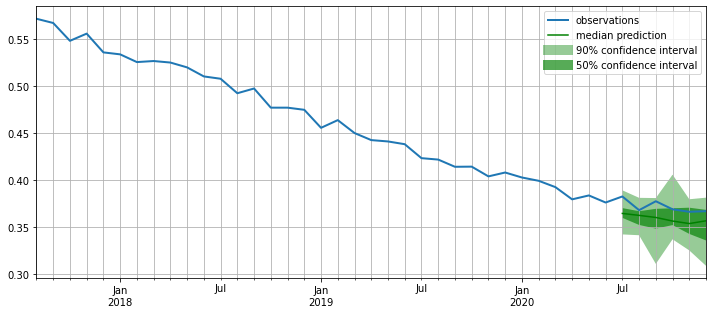

In [510]:
# plot forecast vs true:

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

#num_samples_used_for_ci = 100 # creates n predictions to generate intervall
#forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=num_samples_used_for_ci)
#forecasts = list(forecast_it)
#tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=5)

In [511]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.00024016961705978677,
    "abs_error": 12.678546659648418,
    "abs_target_sum": 384.2466776371002,
    "abs_target_mean": 0.34064421776338666,
    "seasonal_error": 0.04478852195832379,
    "MASE": 0.3104288261438612,
    "MAPE": 0.03763595294431909,
    "sMAPE": 0.03936060356531054,
    "MSIS": 2.211774073803946,
    "QuantileLoss[0.1]": 5.913240119069815,
    "Coverage[0.1]": 0.03280141843971631,
    "QuantileLoss[0.2]": 8.997370539605617,
    "Coverage[0.2]": 0.06914893617021277,
    "QuantileLoss[0.3]": 10.885605303198098,
    "Coverage[0.3]": 0.11258865248226949,
    "QuantileLoss[0.4]": 11.98389028608799,
    "Coverage[0.4]": 0.16666666666666666,
    "QuantileLoss[0.5]": 12.678546655923128,
    "Coverage[0.5]": 0.22429078014184395,
    "QuantileLoss[0.6]": 12.269728006422518,
    "Coverage[0.6]": 0.32092198581560283,
    "QuantileLoss[0.7]": 11.22480281367898,
    "Coverage[0.7]": 0.4450354609929079,
    "QuantileLoss[0.8]": 9.29555251598358,
    "Coverage[0.8]": 

### Train multivariate model

In [512]:
df.isna().sum()

ccg_code                                0
sugg_accept_rate_1_to_7m                0
nletter_open_rate_1_to_7m               0
avg_nb_sugg_per_rep_1_to_7m             0
com_nb_nletter_open_1_to_7m             0
com_ratio_has_consent_in_wkp_1_to_7m    0
xrlt_ms                                 0
dtype: int64

In [832]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': table_target.shape[0],
    'num_steps': table_target.shape[1],
    'prediction_length': 6,
    'freq': 'M',
    'start': [
        pd.Timestamp(df.index.drop_duplicates()[0], freq='M')
        for _ in range(table_target.shape[0])
    ]
}

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  if __name__ == '__main__':


In [833]:
table_target = pd.pivot_table(df, 
                           values='xrlt_ms', 
                           index=['ccg_code'],
                           columns=['yyyymm'],
                           aggfunc=np.sum)
table_target['target'] = table_target.apply(lambda x: np.array(x), axis=1)


In [834]:
target = np.array(table_target['target'].tolist())

In [835]:
features_train = ['sugg_accept_rate_1_to_7m',
                  'nletter_open_rate_1_to_7m',
                  'avg_nb_sugg_per_rep_1_to_7m',
                  'com_nb_nletter_open_1_to_7m']
                  #'com_ratio_has_consent_in_wkp_1_to_7m']

In [836]:
table_target = pd.pivot_table(df, 
                           values=features_train, 
                           index=['ccg_code'],
                           #columns=['yyyymm'],
                           #aggfunc=np.sum
                             )

In [1092]:
df_sorted = df.sort_values(['ccg_code', 'yyyymm']).copy()

feat_dynamic_real = [df_sorted[features_train].iloc[:target.shape[1],:].values.T]
ts_length = target.shape[1]
number_ts = target.shape[0]
count = ts_length

for i in range(number_ts-1):
    curr_idx = ts_length
    feat_dynamic_real = np.vstack((feat_dynamic_real, [df_sorted[
                        features_train].iloc[count:(count+ts_length),:].values.T]))
    count += ts_length
    
#feat_dynamic_real_train = stack[:,:,:-custom_ds_metadata['prediction_length']]
#feat_dynamic_real_test = stack

In [1093]:
# change input for prediction:

feat_dynamic_real[:,:,(ts_length-custom_ds_metadata['prediction_length']):]=1

In [1094]:
# Define fields used
# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:,:,:-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: fdr
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real,
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

In [1095]:
# Returning train and test dict:

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source']) dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


In [1096]:
train_entry['feat_dynamic_real'].shape

(4, 35)

In [1097]:
test_entry['feat_dynamic_real'].shape

(4, 41)

In [1098]:
test_entry

{'target': array([0.68740356, 0.70055735, 0.68368715, 0.67196983, 0.6667347 ,
        0.6554086 , 0.6652938 , 0.64573365, 0.6385187 , 0.64342844,
        0.64250916, 0.63350105, 0.6230409 , 0.61141443, 0.61665547,
        0.618621  , 0.6011318 , 0.6021195 , 0.59865296, 0.59208053,
        0.5941153 , 0.5808847 , 0.57631505, 0.5773291 , 0.600571  ,
        0.56164604, 0.5789036 , 0.5575289 , 0.5716073 , 0.56292105,
        0.5567726 , 0.5674944 , 0.5676967 , 0.5714186 , 0.5712432 ,
        0.56277204, 0.5649941 , 0.55161256, 0.54635006, 0.56037396,
        0.5327857 ], dtype=float32),
 'start': Timestamp('2017-08-31 00:00:00', freq='M'),
 'feat_dynamic_real': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0

In [1099]:
from gluonts import transform

In [1100]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
    AddAggregateLags,
    AddConstFeature,
    AddTimeFeatures,
    cdf_to_gaussian_forward_transform,
    BucketInstanceSampler
)

def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
                imputation_method=transform.MissingValueImputation(),
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=custom_ds_metadata['prediction_length'],
                log_scale=True,
            ),
            #AddConstFeature(
            #output_field=FieldName.FEAT_CONST,
            #target_field=FieldName.TARGET,
            #pred_length=custom_ds_metadata['prediction_length'],
            #const=1.0
            #),
            AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            time_features=[time_feature.MonthOfYearIndex()],
            pred_length=custom_ds_metadata['prediction_length']
            ),
        ]
    )

In [1101]:
transformation = create_transformation(
    custom_ds_metadata['freq'],
    1 * custom_ds_metadata['prediction_length'], # can be any appropriate value
    custom_ds_metadata['prediction_length']
)

train_tf = transformation(iter(train_ds), is_train=True)
test_tf = transformation(iter(test_ds), is_train=False)

print(type(train_tf))
print(transformation.transformations)

<class 'generator'>
[gluonts.transform.feature.AddObservedValuesIndicator(imputation_method=gluonts.transform.feature.MissingValueImputation(), output_field="observed_values", target_field="target"), gluonts.transform.feature.AddAgeFeature(log_scale=True, output_field="feat_dynamic_age", pred_length=6, target_field="target"), gluonts.transform.feature.AddTimeFeatures(output_field="time_feat", pred_length=6, start_field="start", target_field="target", time_features=[gluonts.time_feature._base.MonthOfYearIndex()])]


In [1102]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


['target',
 'start',
 'feat_dynamic_real',
 'source',
 'observed_values',
 'feat_dynamic_age',
 'time_feat']

In [1114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq=custom_ds_metadata['freq'],
                            prediction_length=custom_ds_metadata['prediction_length'],
                            input_size=16,
                            num_layers=2,
                            use_feat_dynamic_real=True,
                            context_length=1*custom_ds_metadata['prediction_length'],
                            #distr_output = NegativeBinomialOutput(),
                            #context_length=2*custom_ds_metadata['prediction_length'],
                            #use_feat_static_cat=True,
                            trainer=Trainer(epochs=5,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [1115]:
# Return forcast and compare with true values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 188/188 [00:00<00:00, 915.87it/s]/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forec

In [1116]:
print(predictor.input_names)
print()
print(estimator.time_features)
print()
print(predictor.freq)
print()
print(estimator.use_feat_dynamic_real)

['feat_static_cat', 'feat_static_real', 'past_time_feat', 'past_target', 'past_observed_values', 'future_time_feat']

[gluonts.time_feature._base.MonthOfYear()]

M

True


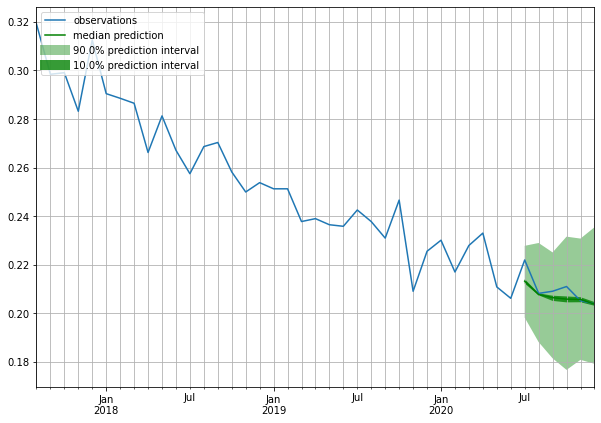

In [1117]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (10.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

id_random = np.random.choice(len(test_ds))
#id_random=1
forecast_entry = forecasts[id_random]
ts_entry = tss[id_random]
plot_prob_forecasts(ts_entry, forecast_entry) 

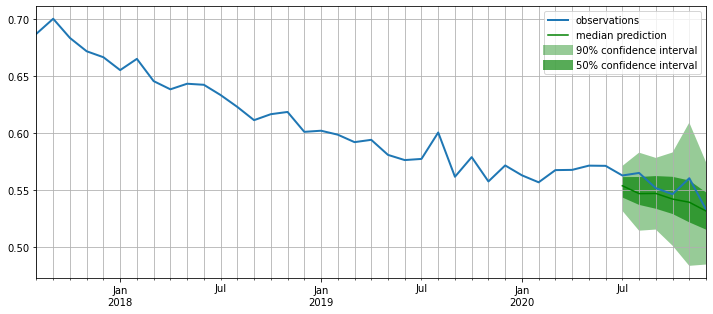

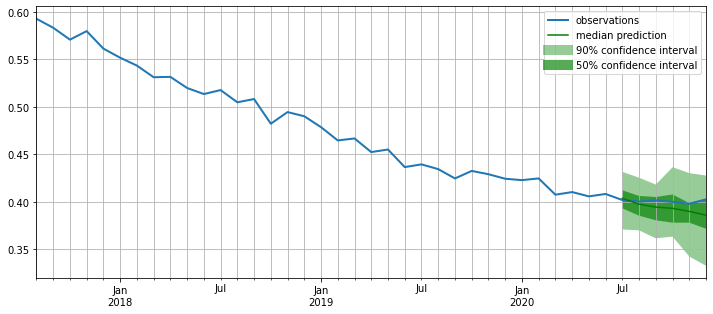

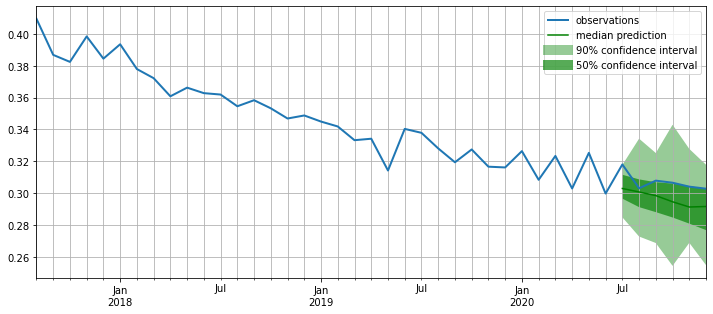

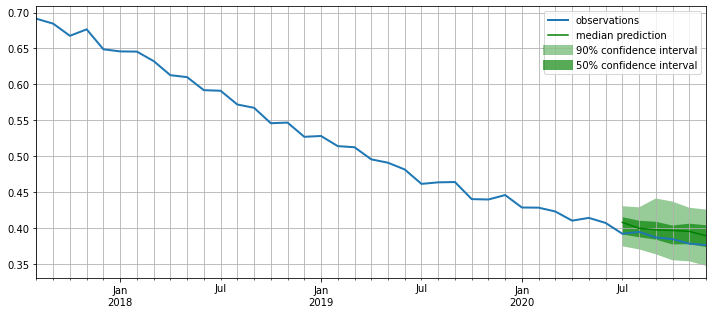

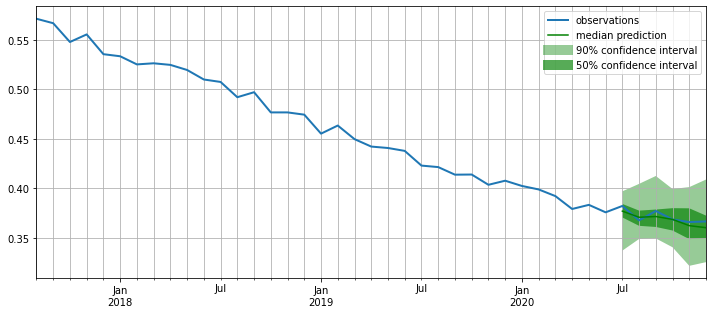

In [1118]:
# Compare forecast vs true

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

#forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
#forecasts = list(forecast_it)
#tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=5)

In [1119]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.00022098126609185103,
    "abs_error": 12.209372155368328,
    "abs_target_sum": 384.2466776371002,
    "abs_target_mean": 0.34064421776338666,
    "seasonal_error": 0.04478852195832379,
    "MASE": 0.3648292954716619,
    "MAPE": 0.03358842545776819,
    "sMAPE": 0.03407016257649777,
    "MSIS": 2.904700071119824,
    "QuantileLoss[0.1]": 6.56148685514927,
    "Coverage[0.1]": 0.035460992907801414,
    "QuantileLoss[0.2]": 9.53925325125456,
    "Coverage[0.2]": 0.08776595744680851,
    "QuantileLoss[0.3]": 11.261644726991653,
    "Coverage[0.3]": 0.1622340425531915,
    "QuantileLoss[0.4]": 12.09792243987322,
    "Coverage[0.4]": 0.25620567375886527,
    "QuantileLoss[0.5]": 12.209372155368328,
    "Coverage[0.5]": 0.35904255319148937,
    "QuantileLoss[0.6]": 11.792856618762016,
    "Coverage[0.6]": 0.46808510638297873,
    "QuantileLoss[0.7]": 10.454000997543336,
    "Coverage[0.7]": 0.6019503546099291,
    "QuantileLoss[0.8]": 8.321020418405531,
    "Coverage[0.8]": 

In [1120]:
mean_fc = np.array([0])*range(custom_ds_metadata['prediction_length'])

for i in range(len(forecasts)):
    forecast_entry = forecasts[i]
    #forecast_entry = forecasts[1]
    #print(forecast_entry.mean)
    mean_fc = mean_fc + forecast_entry.mean
    
highest_mean_fc = mean_fc/len(forecasts)    

In [1121]:
original_mean_fc

array([0.34324231, 0.34009812, 0.33721154, 0.33419385, 0.33178355,
       0.32919219])

In [1122]:
lowest_mean_fc

array([0.34429316, 0.34130432, 0.33901601, 0.33726488, 0.33595351,
       0.33482476])

In [1123]:
highest_mean_fc

array([0.34304051, 0.33989737, 0.33738112, 0.33487759, 0.33179992,
       0.33034015])

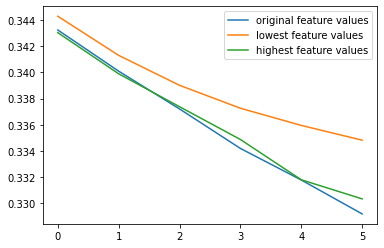

In [1124]:
plt.plot(original_mean_fc, label='original feature values')
plt.plot(lowest_mean_fc, label='lowest feature values')
plt.plot(highest_mean_fc, label='highest feature values')
#plt.plot(absurd_mean_fc, label='absurd')
plt.legend()